In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

In [2]:

def Data_intergate(y, pday):
    y = np.array(y)
    y_process = []
    for i in range(y.shape[0]):
        if i + pday < y.shape[0]:
            Tmp_y = np.array([])
            for p in range(pday):
                Tmp_y = np.append(Tmp_y, y[i+p+1])
            y_process.append(Tmp_y)
    y_process = np.array(y_process)
    return y_process

In [3]:
# Assuming 'df' is your DataFrame and the 'Date' column is already in datetime format
data = pd.read_csv("data/AAPL_process.csv")
data['Date'] = pd.to_datetime(data['Date'])
# Filter the DataFrame to include only records after January 1st, 2018
data= data[data['Date'] > '2017-12-31']
data

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
251,2018-01-02,43.064999,-0.687500,-0.427501,-0.102501,38.095207,23.518897,42.687000,42.861915,43.226750,...,0.096744,51.908436,54.415138,-61.904793,-45.996327,-22.526228,-17.617694,-56.549719,20.849926,70.141218
252,2018-01-03,43.057499,0.414997,-1.047501,0.132500,37.719267,27.015462,42.770000,42.927110,43.122000,...,0.093779,51.823304,54.371954,-62.280733,-46.275657,-22.663027,-17.724684,3.332019,49.139985,84.186908
253,2018-01-04,43.257500,0.607498,-0.377498,0.189999,47.744385,41.186286,42.891499,43.037240,43.084250,...,0.106341,53.990300,55.351821,-52.255615,-38.826822,-19.015037,-14.871602,0.511805,45.578460,81.809831
254,2018-01-05,43.750000,0.980000,0.162498,0.695000,72.431114,52.631589,43.087499,43.274826,43.100500,...,0.154260,58.893606,57.673063,-27.568886,-20.484157,-10.031905,-7.845922,56.357004,80.215917,95.100417
255,2018-01-08,43.587502,1.280003,-0.164997,0.095002,64.285847,61.487115,43.343500,43.379052,43.084000,...,0.177082,56.744824,56.665046,-35.714153,-26.536231,-13.956849,-10.164011,56.800458,82.911434,94.322985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,2024-01-22,193.889999,7.970001,12.710006,1.360000,90.501302,76.309535,188.078000,189.720959,186.878999,...,-0.407919,60.687256,56.725696,-9.498698,-29.460138,-29.460138,-16.877751,228.423010,68.434112,97.990256
1774,2024-01-23,195.179993,11.549988,9.619995,9.539994,96.341419,88.961636,190.387998,191.540637,187.840999,...,0.183658,62.619641,57.871310,-3.658581,-22.827777,-22.827777,-13.078063,179.176745,84.689013,105.292992
1775,2024-01-24,194.500000,11.820007,9.360001,10.250000,88.402195,91.748305,192.751999,192.527091,188.776999,...,0.590807,60.919755,57.045762,-11.597805,-26.323886,-26.323886,-15.080988,136.147483,84.511888,104.742010
1776,2024-01-25,194.169998,5.539993,7.979996,12.259994,86.366403,90.370006,193.859998,193.074727,189.574998,...,0.876741,60.067546,56.639129,-13.633597,-28.020554,-28.020554,-16.053012,103.672031,71.819686,98.338499


In [4]:
next_days = 7
# Load Data

X_train = data[(data['Date'] > '2017-12-31')& (data['Date'] < '2023-01-01')]
X_train

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
251,2018-01-02,43.064999,-0.687500,-0.427501,-0.102501,38.095207,23.518897,42.687000,42.861915,43.226750,...,0.096744,51.908436,54.415138,-61.904793,-45.996327,-22.526228,-17.617694,-56.549719,20.849926,70.141218
252,2018-01-03,43.057499,0.414997,-1.047501,0.132500,37.719267,27.015462,42.770000,42.927110,43.122000,...,0.093779,51.823304,54.371954,-62.280733,-46.275657,-22.663027,-17.724684,3.332019,49.139985,84.186908
253,2018-01-04,43.257500,0.607498,-0.377498,0.189999,47.744385,41.186286,42.891499,43.037240,43.084250,...,0.106341,53.990300,55.351821,-52.255615,-38.826822,-19.015037,-14.871602,0.511805,45.578460,81.809831
254,2018-01-05,43.750000,0.980000,0.162498,0.695000,72.431114,52.631589,43.087499,43.274826,43.100500,...,0.154260,58.893606,57.673063,-27.568886,-20.484157,-10.031905,-7.845922,56.357004,80.215917,95.100417
255,2018-01-08,43.587502,1.280003,-0.164997,0.095002,64.285847,61.487115,43.343500,43.379052,43.084000,...,0.177082,56.744824,56.665046,-35.714153,-26.536231,-13.956849,-10.164011,56.800458,82.911434,94.322985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,131.860001,-2.649994,-10.300003,-14.770004,10.919832,16.161731,132.841998,133.506590,136.839000,...,-3.670694,35.675357,41.197211,-89.080168,-90.730679,-92.031580,-95.226828,-101.644186,-182.093258,-150.514652
1506,2022-12-27,130.029999,-2.339996,-14.460006,-12.880005,6.164696,9.403825,132.373999,132.347726,135.392999,...,-3.936230,33.658569,40.125842,-93.835304,-94.537122,-95.448235,-97.238039,-101.949857,-188.157271,-157.616154
1507,2022-12-28,126.040001,-6.260002,-19.430000,-14.900001,0.705386,5.929971,131.121999,130.245151,133.449999,...,-4.417705,29.714325,37.897425,-99.294614,-99.366388,-99.462542,-99.661897,-114.020378,-203.667054,-173.017671
1508,2022-12-29,129.610001,-5.839996,-13.600006,-13.039993,15.518665,7.462916,129.954000,130.033434,132.089999,...,-4.459798,36.845375,40.940761,-84.481335,-86.060385,-88.175788,-92.561657,-84.005432,-168.519734,-157.558344


In [5]:
data1 = pd.read_csv("data/AAPL_process.csv")
y_train = Data_intergate(data1['Close'][251:1517], next_days)
y_train

array([[ 43.057499,  43.2575  ,  43.75    , ...,  43.5825  ,  43.572498,
         43.82    ],
       [ 43.2575  ,  43.75    ,  43.587502, ...,  43.572498,  43.82    ,
         44.272499],
       [ 43.75    ,  43.587502,  43.5825  , ...,  43.82    ,  44.272499,
         44.047501],
       ...,
       [129.610001, 129.929993, 125.07    , ..., 125.019997, 129.619995,
        130.149994],
       [129.929993, 125.07    , 126.360001, ..., 129.619995, 130.149994,
        130.729996],
       [125.07    , 126.360001, 125.019997, ..., 130.149994, 130.729996,
        133.490005]])

In [6]:
len(y_train)

1259

In [7]:
X_test = data1[1510:1770]
X_test

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
1510,2023-01-03,125.070000,-6.790001,-9.439995,-19.420005,3.488379,11.951159,128.135999,128.355969,130.488999,...,-4.719808,32.329408,38.461621,-96.511621,-96.746197,-97.299724,-98.268561,-103.679305,-169.910138,-172.013538
1511,2023-01-04,126.360001,-3.669998,-6.009994,-19.110000,9.737672,10.024161,127.401999,127.690647,129.887999,...,-4.800807,34.878067,39.570440,-90.262328,-92.082420,-93.429334,-95.786835,-103.510019,-157.908118,-169.167337
1512,2023-01-05,125.019997,-1.020004,-7.280006,-18.190010,4.821320,6.015791,127.197998,126.800430,129.159999,...,-4.916453,33.467992,38.817003,-95.178680,-96.822434,-97.449748,-98.364757,-112.881065,-155.162533,-172.853388
1513,2023-01-06,129.619995,0.009994,-5.830002,-6.880005,40.430257,18.329750,127.199997,127.740285,128.576998,...,-4.584079,42.118917,42.700916,-59.569743,-79.626179,-83.648375,-89.515203,-50.024251,-124.502934,-151.427825
1514,2023-01-09,130.149994,0.220001,-2.080002,-4.360001,47.310095,30.853891,127.243997,128.543521,128.368998,...,-4.229153,43.037926,43.132253,-52.689905,-77.644875,-82.058219,-88.495582,38.356542,-92.445410,-126.703325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,2024-01-09,185.139999,-0.500000,-8.460007,-10.750000,28.383795,21.568835,183.607999,185.014005,187.598999,...,-1.611037,40.601394,47.294277,-71.616205,-74.447292,-44.159802,-42.650949,-69.924211,-38.780415,17.527863
1766,2024-01-10,186.190002,1.940002,-6.860001,-10.750000,34.380387,31.182200,183.995999,185.406004,186.912999,...,-1.607493,43.327876,48.522963,-65.619613,-69.048818,-42.339195,-39.558157,-46.287692,-32.105633,27.306438
1767,2024-01-11,185.589996,3.679992,-7.559998,-9.240006,32.052021,31.605401,184.731998,185.467335,186.156999,...,-1.634261,42.137605,47.861766,-67.947979,-72.133682,-44.230765,-41.325479,-40.235819,-39.389322,25.671279
1768,2024-01-12,185.919998,4.740005,-7.660004,-8.759995,37.729644,34.720684,185.679999,185.618222,185.390999,...,-1.610284,43.064031,48.263865,-62.270356,-70.437013,-46.440668,-40.353456,-26.091288,-39.665808,29.722478


In [8]:
len(X_test)

260

In [9]:
y_test = Data_intergate(data1['Close'][1510:1777], next_days)
y_test

array([[126.360001, 125.019997, 129.619995, ..., 130.729996, 133.490005,
        133.410004],
       [125.019997, 129.619995, 130.149994, ..., 133.490005, 133.410004,
        134.759995],
       [129.619995, 130.149994, 130.729996, ..., 133.410004, 134.759995,
        135.940002],
       ...,
       [185.919998, 183.630005, 182.679993, ..., 191.559998, 193.889999,
        195.179993],
       [183.630005, 182.679993, 188.630005, ..., 193.889999, 195.179993,
        194.5     ],
       [182.679993, 188.630005, 191.559998, ..., 195.179993, 194.5     ,
        194.169998]])

In [10]:
len(y_test)

260

In [11]:
X_train.to_csv('./FE_results_7day/Train_original.csv')
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Date'])


X_test.to_csv('./FE_results_7day/Test_original.csv')
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Date'])

y_train = DataFrame(y_train)
y_train.to_csv('./FE_results_7day/y_train.csv')
y_test = DataFrame(y_test)
y_test.to_csv('./FE_results_7day/y_test.csv')
print('Original number of features: ', data.shape[1])

Original number of features:  32


In [31]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import pandas as pd
import numpy as np

# Assuming X_train and y_train are your feature and label datasets, respectively
important_features_set = set()

for label_index in range(y_train.shape[1]):  # Loop through each label
    print(f"Running Boruta for label {label_index}")
    
    # Define the random forest that will be used by Boruta
    rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=42)
    
    # Initialize Boruta
    feat_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=2, max_iter=100)
    
    # Fit Boruta (it expects numpy arrays)
    feat_selector.fit(X_train.values, y_train.iloc[:, label_index].values)
    
    # Find the features that Boruta marks as important or tentative
    features_selected = X_train.columns[feat_selector.support_ | feat_selector.support_weak_]
    print(f"Selected features for label {label_index}: {features_selected}")
    
    # Add the selected features to the set of all important features
    important_features_set.update(features_selected)

# Convert the set to a list to index DataFrame columns
important_features_list = list(important_features_set)
print(f"All important features across labels: {important_features_list}")


Running Boruta for label 0
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	0
Selected features for label 0: Index(['0', '1', '2'], dtype='object')
Running Boruta for label 1
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	3
Rejec

In [30]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import pandas as pd

# Initialize a list to hold the Boruta results for each target
boruta_results = []

for target_col in range(y_train.shape[1]): # Assuming y_train is a DataFrame with 7 columns
    print(f'######Boruta Feature Selection for Target Column: {target_col}######')
    rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1) # Added random_state for reproducibility
    feat_selector.fit(X_train.values, y_train.values[:, target_col])
    
    # Store the results
    boruta_results.append({
        'target_col': target_col,
        'num_features': np.sum(feat_selector.support_),
        'features': X_train.columns[feat_selector.support_].values,
        'support': feat_selector.support_,
        'support_weak': feat_selector.support_weak_,
        'ranking': feat_selector.ranking_
    })
    
    print(f'The number of features after Boruta for target {target_col}: ', np.sum(feat_selector.support_))
    print('Remained Features:', X_train.columns[feat_selector.support_].values)

# Example of how to access results for the first target column
print(boruta_results[0]['features'])


######Boruta Feature Selection for Target Column: 0######
The number of features after Boruta for target 0:  3
Remained Features: ['0' '1' '2']
######Boruta Feature Selection for Target Column: 1######
The number of features after Boruta for target 1:  3
Remained Features: ['0' '1' '2']
######Boruta Feature Selection for Target Column: 2######
The number of features after Boruta for target 2:  3
Remained Features: ['0' '1' '2']
######Boruta Feature Selection for Target Column: 3######
The number of features after Boruta for target 3:  3
Remained Features: ['0' '1' '2']
######Boruta Feature Selection for Target Column: 4######
The number of features after Boruta for target 4:  3
Remained Features: ['0' '1' '2']
######Boruta Feature Selection for Target Column: 5######
The number of features after Boruta for target 5:  3
Remained Features: ['0' '1' '2']
######Boruta Feature Selection for Target Column: 6######
The number of features after Boruta for target 6:  3
Remained Features: ['0' '

In [18]:
# Feature Engineering
# Boruta
print('######Boruta######')
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto')
X_train_boruta = feat_selector.fit_transform(X_train.values, y_train.values[:, 6])
X_test_boruta = feat_selector.transform(X_test.values)
print('The number of features after Boruta: ', np.sum(feat_selector.support_==True))
print('Remained Feature:')
print(X_train.columns[feat_selector.support_].values)
Train_boruta = DataFrame(X_train_boruta)
Train_boruta.insert(0, 'Date', Train_date.values)
Test_boruta = DataFrame(X_test_boruta)
Test_boruta.insert(0, 'Date', Test_date.values)
Train_boruta.to_csv('./FE_results_7day/Train_boruta.csv')
Test_boruta.to_csv('./FE_results_7day/Test_boruta.csv')

######Boruta######
The number of features after Boruta:  31
Remained Feature:
['Close' 'MOM_5' 'MOM_10' 'MOM_14' 'STCK' 'STCD' 'close_5_sma'
 'close_5_ema' 'close_10_sma' 'close_10_ema' 'close_14_sma' 'close_14_ema'
 'close_30_sma' 'close_30_ema' 'close_50_sma' 'close_50_ema'
 'close_100_sma' 'close_100_ema' 'close_200_sma' 'close_200_ema'
 'macd_26_13_19' 'macd_45_25_15' 'rsi_14' 'rsi_28' 'wr_14' 'wr_28' 'wr_50'
 'wr_100' 'cci_14' 'cci_50' 'cci_100']


In [15]:
y_train.values[:, 6]

array([ 43.82    ,  44.272499,  44.047501, ..., 130.149994, 130.729996,
       133.490005])

#########PCA#########
The number of features after PCA:  5


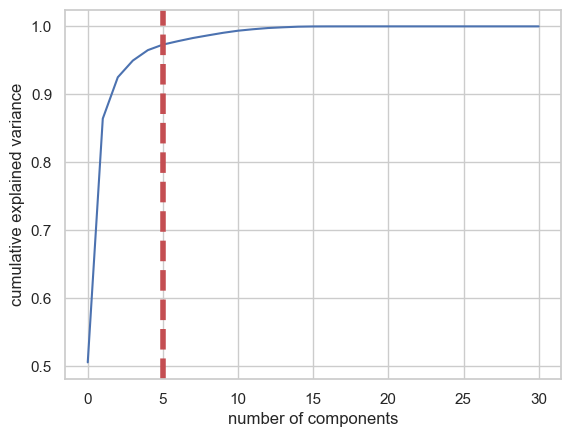

   Cumulative Variance Ratio  Explained Variance Ratio
0                   0.505919                  0.505919
1                   0.864312                  0.358393
2                   0.925178                  0.060866
3                   0.949700                  0.024522
4                   0.965068                  0.015368
#########t-SNE#########
The number of features after t-SNE:  3
KL divergence:  0.1878826916217804


In [19]:
# PCA
print("#########PCA#########")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print('The number of features after PCA: ', pca.n_components_)
Train_pca = DataFrame(X_train_pca)
Train_pca.insert(0, 'Date', Train_date.values)
Test_pca = DataFrame(X_test_pca)
Test_pca.insert(0, 'Date', Test_date.values)
Train_pca.to_csv('./FE_results_7day/Train_pca.csv')
Test_pca.to_csv('./FE_results_7day/Test_pca.csv')
# plot
pca_all = PCA(n_components=31)
pca_all.fit(X_train_scaled)
evr = pca_all.explained_variance_ratio_
cvr = np.cumsum(evr)
sns.set(style='whitegrid')
plt.plot(cvr)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle='--', x=pca.n_components_, ymin=0, ymax=1)
plt.show()
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
print(pca_df.head(pca.n_components_))

# t-SNE
print("#########t-SNE#########")
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)
print('The number of features after t-SNE: ', X_train_tsne.shape[1])
print('KL divergence: ', tsne.kl_divergence_)
Train_tsne = DataFrame(X_train_tsne)
Train_tsne.insert(0, 'Date', Train_date.values)
Test_tsne = DataFrame(X_test_tsne)
Test_tsne.insert(0, 'Date', Test_date.values)
Train_tsne.to_csv('./FE_results_7day/Train_tsne.csv')
Test_tsne.to_csv('./FE_results_7day/Test_tsne.csv')



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [21]:
pd.set_option('display.max_colwidth', None)

####### Without Feature Engineering #######
############################################

 trial: 1

 ############################################


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__f

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.2s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e+01, tolerance: 1.148e+01
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+01, tolerance: 1.164e+01
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.2s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+02, tolerance: 1.956e+02
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e+02, tolerance: 1.961e+02
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.1s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.1s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.1s


/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)




# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_fe

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=   8.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  13.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  15.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  19.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  23.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  11.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  21.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  27.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  37.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  46.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   5.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   7.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   9.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  12.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  14.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=   8.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  12.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  17.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  21.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  25.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


Results                    Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   2.725823    3.826533   5.900444   6.846341   
Lasso               2.784159    3.971046   3.664794   4.518831   
Random Forest       1.354841    1.954938  12.335342  14.961288   
LSTM                8.871459   15.005022  43.695303  46.601889   

                                                                                                                           Best Params  
Linear Regression                                                                                   {'regressor__fit_intercept': True}  
Lasso                                                                             {'regressor__alpha': 1, 'regressor__max_iter': 1000}  
Random Forest      {'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}  
LSTM                                                                            {'batch_size': 32, 'epochs': 100,

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e+01, tolerance: 1.148e+01
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+01, tolerance: 1.164e+01
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.2s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+02, tolerance: 1.956e+02
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e+02, tolerance: 1.961e+02
  model = cd_fast.enet_coordinate_descent(
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.1s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.1s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.1s


/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)




# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_fe

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=   7.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  12.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  15.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  20.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  24.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  13.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  24.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  28.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  37.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  45.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   6.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   8.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  10.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  12.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  15.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=   9.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  13.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  19.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  22.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  26.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 



##################################################
Boruta
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   2.725823    3.826533   5.900444   6.846341   
Lasso               2.784159    3.971046   3.664794   4.518831   
Random Forest       0.614262    0.949744  11.813152  14.445662   
LSTM                9.514588   16.330584  46.531231  49.275778   

                                                                                                                            Best Params  
Linear Regression                                                                                    {'regressor__fit_intercept': True}  
Lasso                                                                              {'regressor__alpha': 1, 'regressor__max_iter': 1000}  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
LSTM                                                     

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=   9.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  11.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  15.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  19.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  22.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  12.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  20.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  25.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  32.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  43.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   7.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   9.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  10.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  12.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  15.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=   9.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  14.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  17.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  21.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  25.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 



##################################################
PCA
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   3.023006    4.267499  75.610667  81.069273   
Lasso               3.129904    4.369033  75.610667  81.017314   
Random Forest       1.348533    1.919467  68.853704  72.998228   
LSTM                7.937200   13.723327  75.691289  79.391602   

                                                                                                                            Best Params  
Linear Regression                                                                                    {'regressor__fit_intercept': True}  
Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
Random Forest      {'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}  
LSTM                                                        

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=   9.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  13.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  16.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  24.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  24.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  13.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  20.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  27.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  34.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  41.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   8.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   9.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  10.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  13.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  14.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=   9.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  13.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  16.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  20.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  23.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_58867/3433588895.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)




##################################################
t-SNE
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression  13.007426   16.009103  72.130037  74.596970   
Lasso              13.004941   16.010538  72.180126  74.648105   
Random Forest       1.323813    1.909713  73.328393  78.937993   
LSTM                8.896375   14.312273  66.736066  72.158707   

                                                                                                                            Best Params  
Linear Regression                                                                                    {'regressor__fit_intercept': True}  
Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
LSTM                                                      

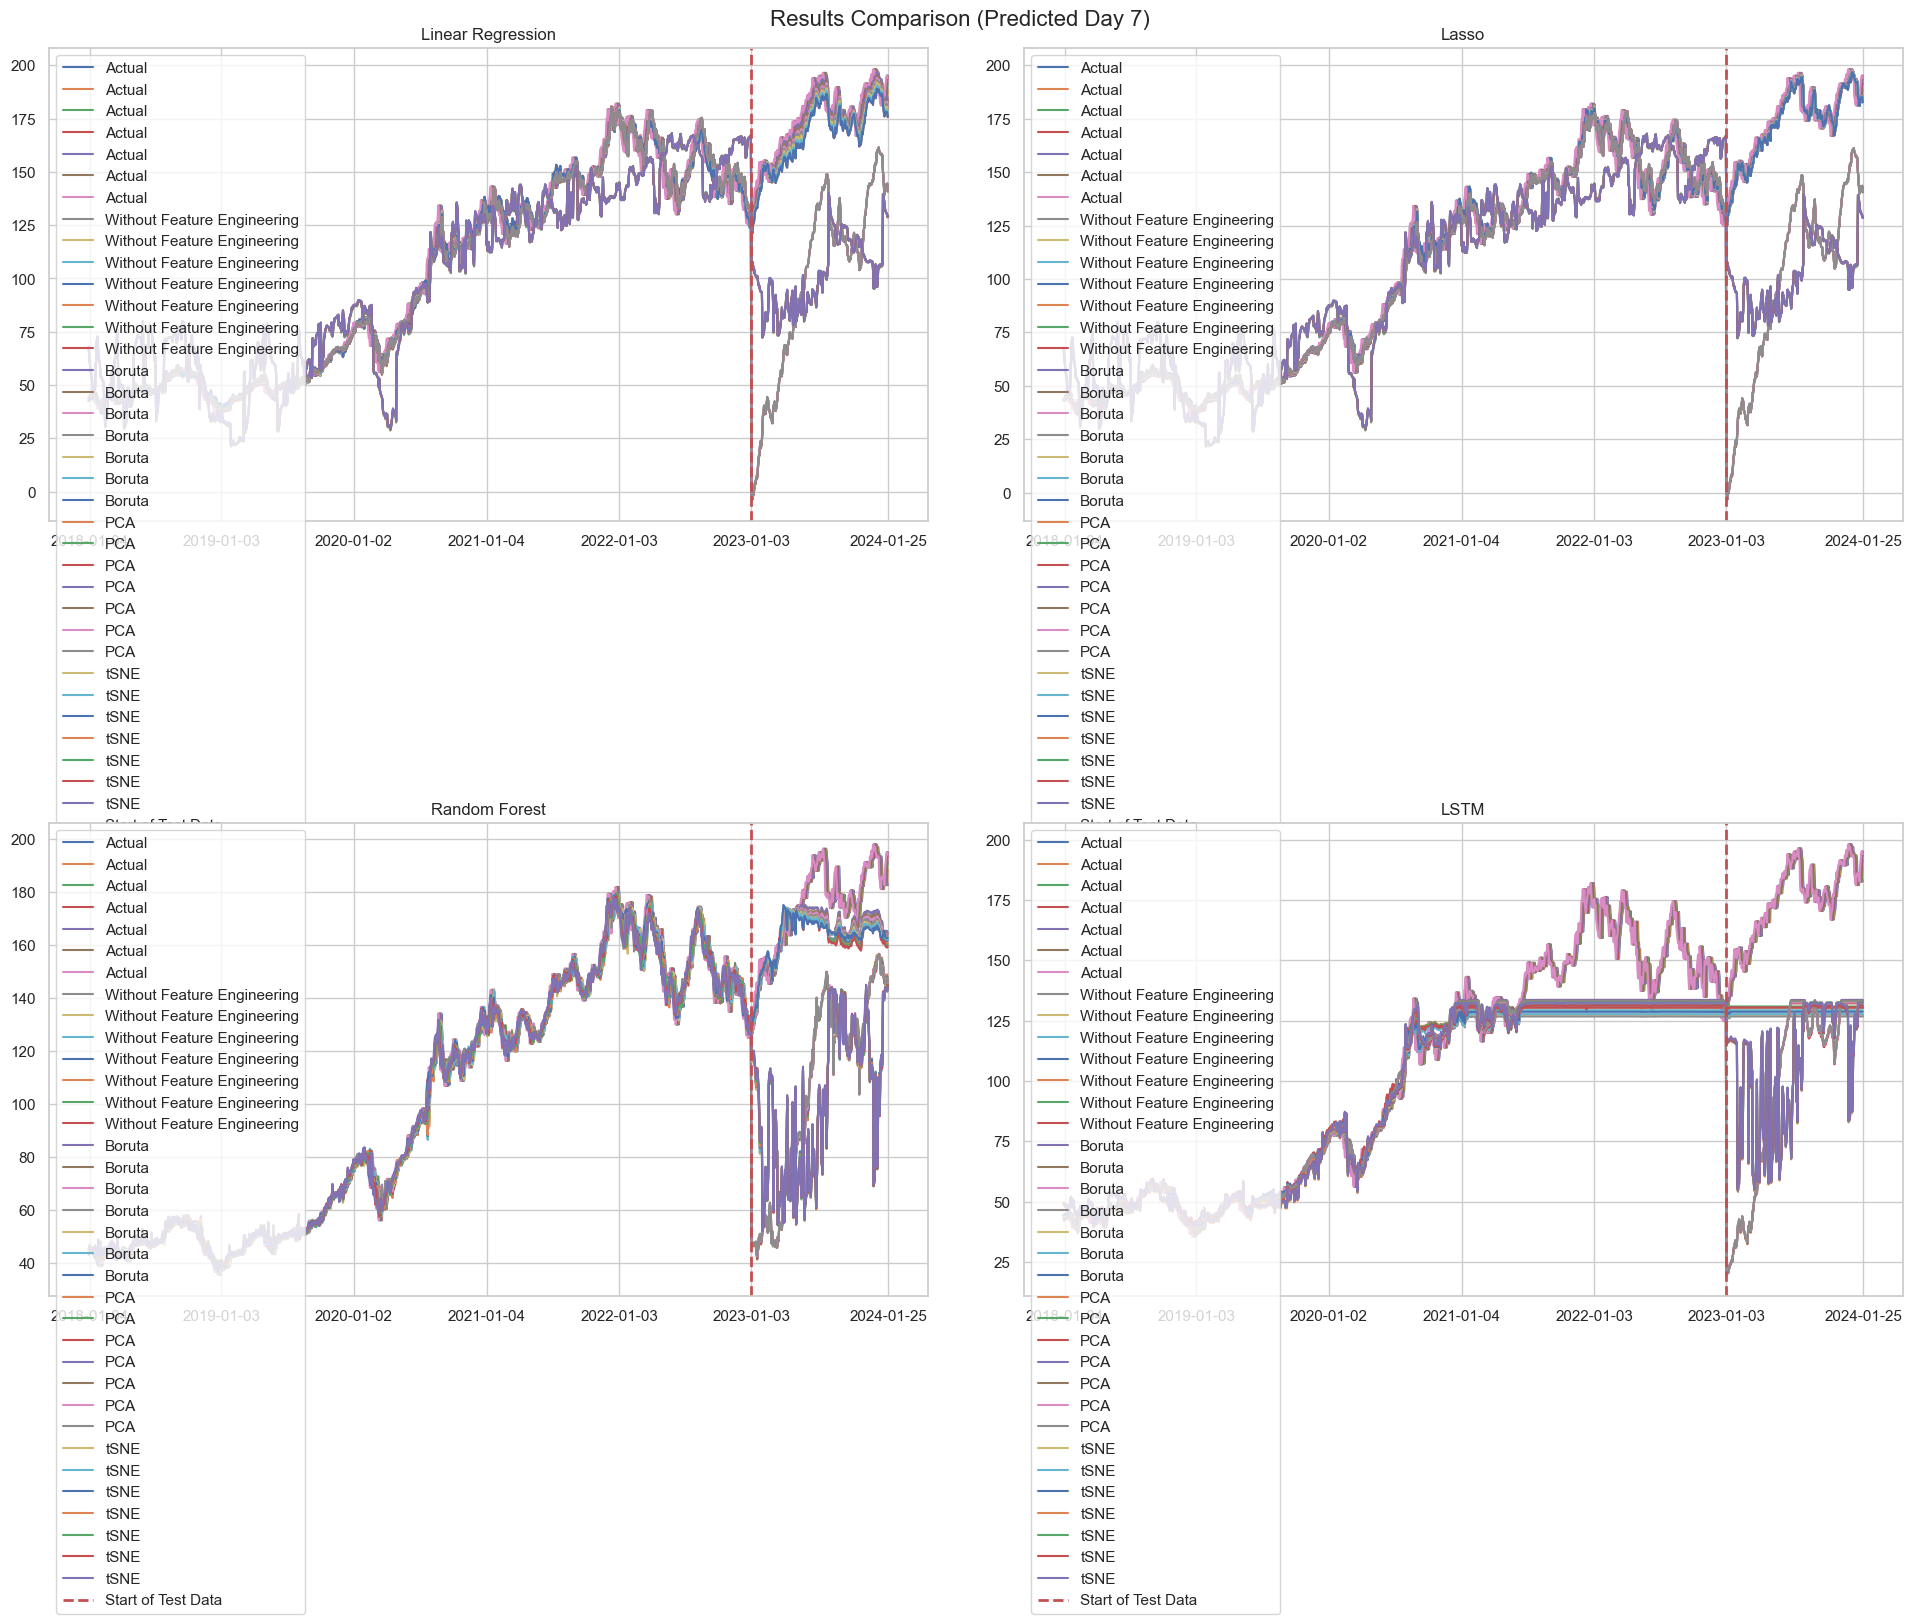

In [26]:
def create_lstm_model(input_shape, num_outputs=7, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(num_outputs))  # Adjusted for multi-output
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def Model_training(model, X_train, y_train, X_test, y_test, pred_list):
    result = {}
    
    model.fit(X_train, y_train.values)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    pred_list.append(np.concatenate((train_pred, test_pred), axis=0))

    # Calculate metrics per output and then average, or adapt as necessary
    result['Train MAE'] = np.mean([mean_absolute_error(y_train.iloc[:, i], train_pred[:, i]) for i in range(y_train.shape[1])])
    result['Train RMSE'] = np.mean([np.sqrt(mean_squared_error(y_train.iloc[:, i], train_pred[:, i])) for i in range(y_train.shape[1])])
    result['Test MAE'] = np.mean([mean_absolute_error(y_test.iloc[:, i], test_pred[:, i]) for i in range(y_test.shape[1])])
    result['Test RMSE'] = np.mean([np.sqrt(mean_squared_error(y_test.iloc[:, i], test_pred[:, i])) for i in range(y_test.shape[1])])

    
    if isinstance(model, GridSearchCV):
        result['Best Params'] = model.best_params_
    
    return result


def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []

    print('\n\n# Linear Regression')
    pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    params_lr = {'regressor__fit_intercept': [True, False]}
    model_lr = GridSearchCV(pipeline_lr, params_lr, cv=cv, verbose=verbose)
    result_lr = Model_training(model_lr, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lr, ignore_index=True)

    print('\n\n# Lasso')
    pipeline_lasso = Pipeline([('regressor', Lasso())])
    params_lasso = {'regressor__alpha': [0.5, 1], 'regressor__max_iter': [1000]}
    model_lasso = GridSearchCV(pipeline_lasso, params_lasso, cv=cv, verbose=verbose)
    result_lasso = Model_training(model_lasso, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lasso, ignore_index=True)

    print('\n\n# Random Forest')
    regressor_rf = RandomForestRegressor()
    params_rf = {
        'max_depth': [8, 16, 24],
        'n_estimators': [100, 200],
        'criterion': ['squared_error'],
        'min_samples_split': [2, 4],
        'max_features': ['sqrt']
    }
    model_rf = GridSearchCV(regressor_rf, params_rf, cv=cv, verbose=verbose)
    result_rf = Model_training(model_rf, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_rf, ignore_index=True)

    print('\n\n# LSTM')
    input_shape = (X_train.shape[1], 1)
    regressor_lstm = KerasRegressor(build_fn=lambda: create_lstm_model(input_shape), epochs=100, batch_size=64, verbose=0)
    params_lstm = {'batch_size': [32, 64], 'epochs': [50, 100], 'optimizer': ['adam']}
    model_lstm = GridSearchCV(estimator=regressor_lstm, param_grid=params_lstm, cv=cv, verbose=verbose)
    result_lstm = Model_training(model_lstm, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lstm, ignore_index=True)

    Results.index = [model_name[i] for i in range(4)]
    return Results, pred_list




model_name = {0: 'Linear Regression', 1: 'Lasso', 2: 'Random Forest', 3: 'LSTM'}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
based_days = 7
next_days = 7
pred_total = {}


# Pre-Loading
y_train = pd.read_csv("FE_results_7day/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE_results_7day/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])

# Without Feature Engineering
print('####### Without Feature Engineering #######')
# Load Data
X_train = pd.read_csv("FE_results_7day/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE_results_7day/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

for trial in range(1, 2):

    print(f'############################################\n\n trial: {trial}\n\n ############################################')

    results_total = []

    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

    print(f'Results {Results}')
    print(f'pred_list {pred_list}')
    results_total.append(Results)

    print('\n\n##################################################\nWithout Feature Engineering')
    print(Results)
    pred_total['Without Feature Engineering'] = pred_list

    # Boruta
    print('\n####### Boruta #######')
    # Load Data
    X_train = pd.read_csv('./FE_results_7day/Train_boruta.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE_results_7day/Test_boruta.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nBoruta')
    print(Results)
    pred_total['Boruta'] = pred_list

    # PCA
    print('\n####### PCA #######')
    # Load Data
    X_train = pd.read_csv('./FE_results_7day/Train_pca.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE_results_7day/Test_pca.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nPCA')
    print(Results)
    pred_total['PCA'] = pred_list

    # t-SNE
    print('\n####### t-SNE #######')
    # Load Data
    X_train = pd.read_csv('./FE_results_7day/Train_tsne.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE_results_7day/Test_tsne.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nt-SNE')
    print(Results)
    pred_total['tSNE'] = pred_list

    # Save Results
    results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

    results_.to_csv(f'./Model performance/7day_results_{trial}.csv')
    # Visualization
    # Before your plotting code, you can adjust the default plot size like this
    plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
    date = np.concatenate((Train_date, Test_date), axis=0)
    axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
    y_actual = np.concatenate((y_train, y_test), axis=0)
    # For each subplot, you can now set individual titles and labels without them overlapping.
    for key, value in model_name.items():
        ax = plt.subplot(2, 2, key + 1)
        model = key
        ax.set_title(value)
        plt.plot(y_actual, label='Actual')
        for key, value in pred_total.items():
            plt.plot(date, value[model], label=key)
        
        # Ensure the x parameter matches the format and actual point where the test data starts
        plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
        
        # Rotate xticks if they are overlapping
        
        # Set xticks to be more sparse to prevent overlap
        #plt.xticks(ticks=np.arange(0, len(date), step=int(len(date)/len(axis_x))), labels=axis_x)
        plt.xticks(axis_x)
        plt.legend()

    # Adjust layout spacing to prevent labels and titles from overlapping
    plt.tight_layout(pad=3.0)

    # You can add a super title for the entire figure if you want
    plt.suptitle('Results Comparison (Predicted Day 7)', fontsize=16)

    # Show the plot
    plt.show()


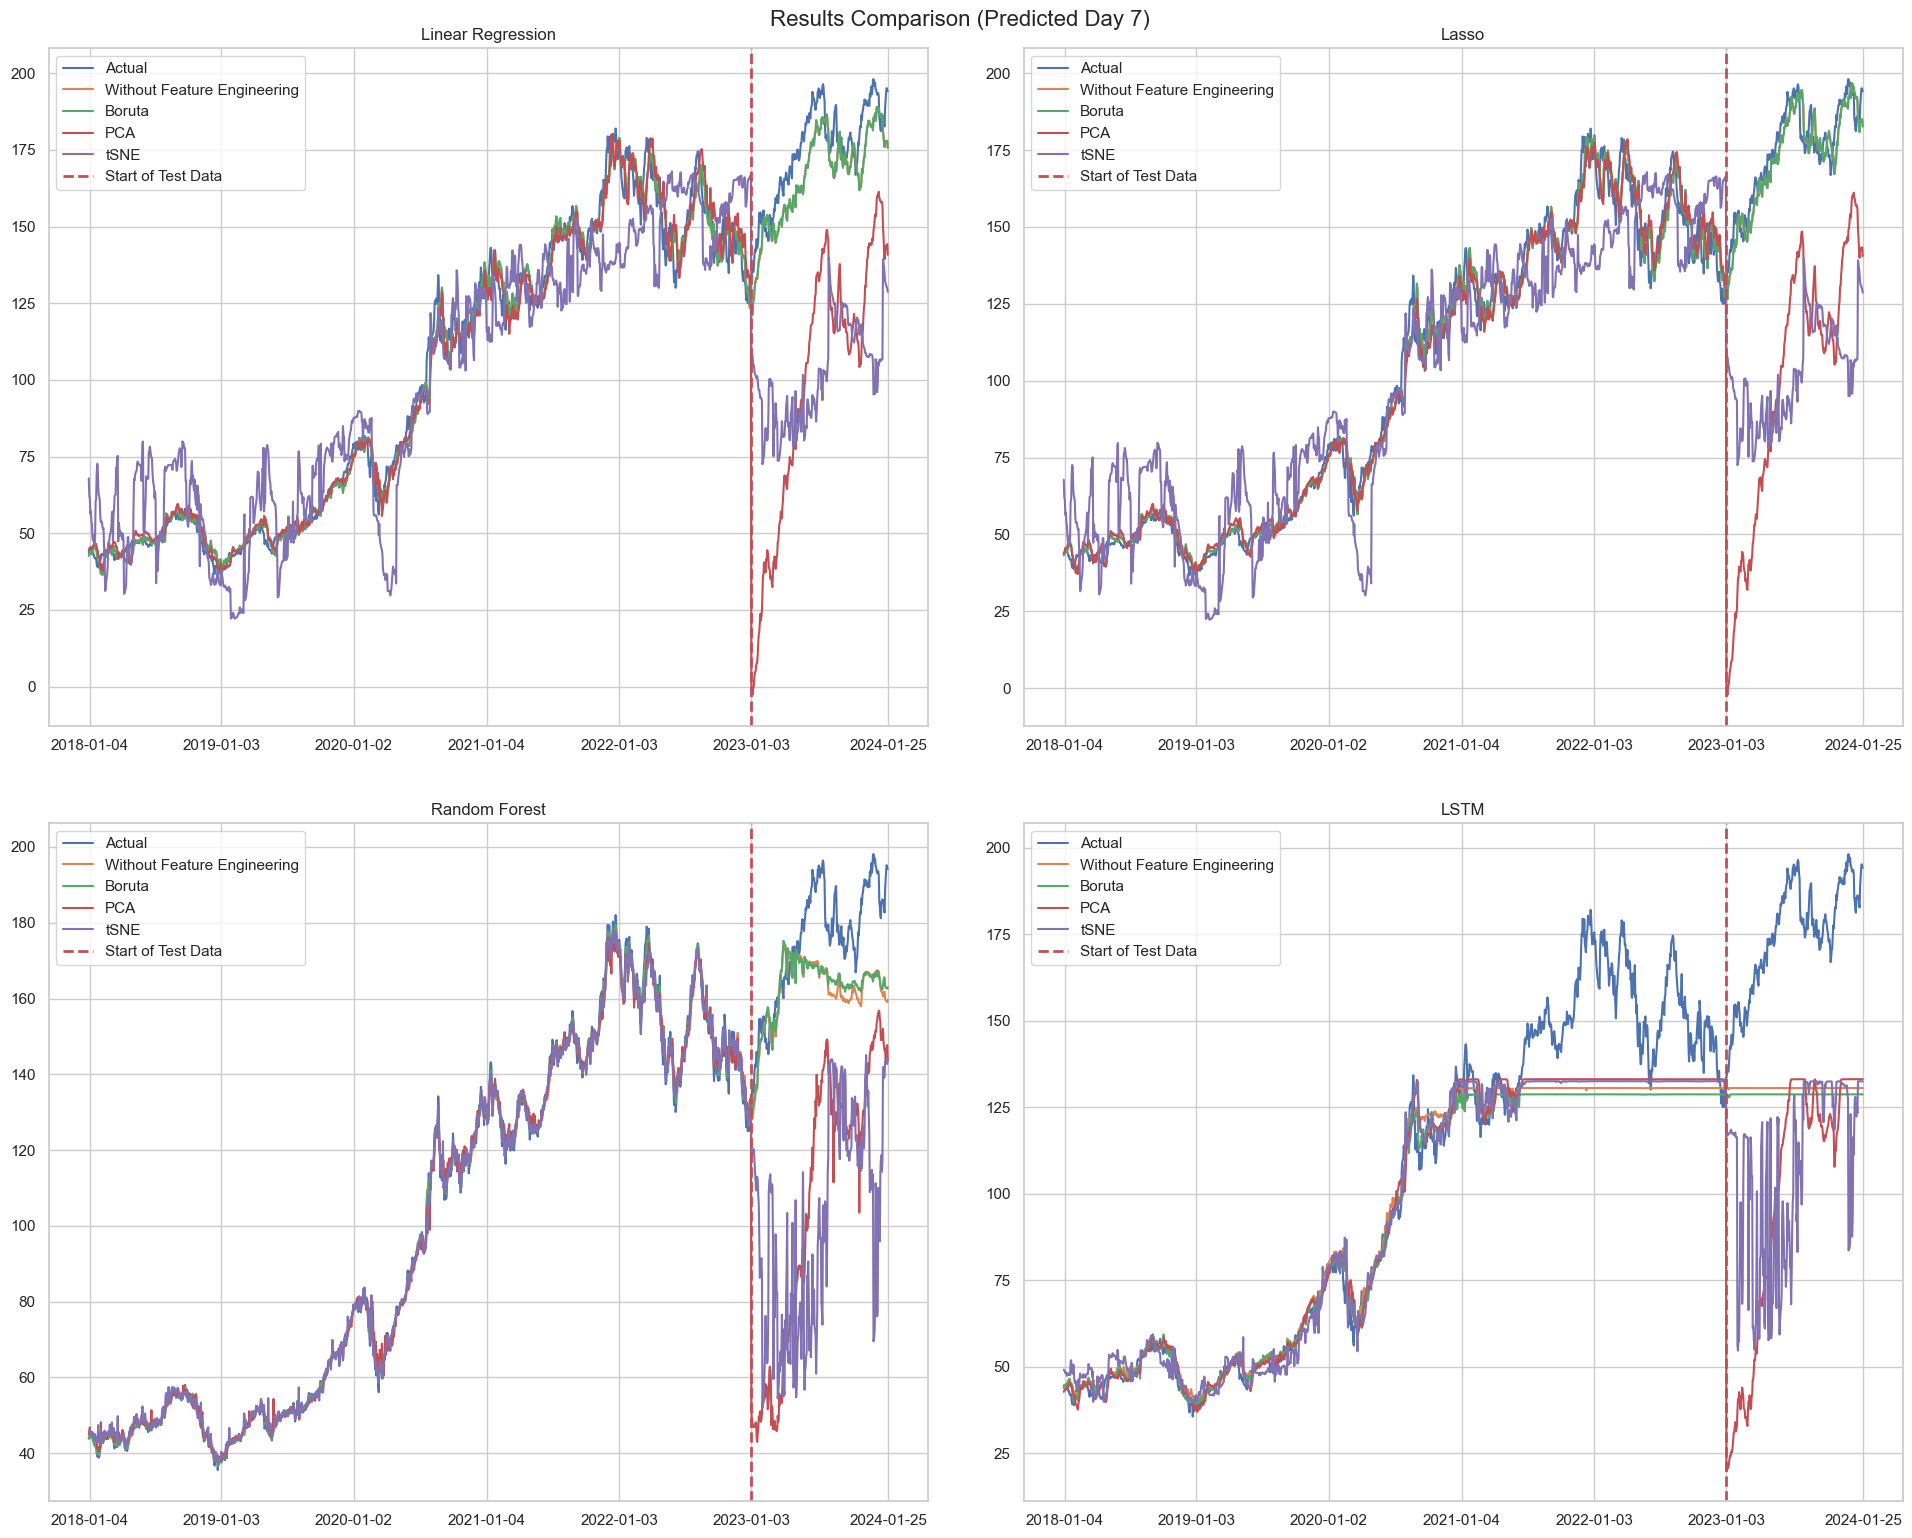

In [28]:
plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)
    # For each subplot, you can now set individual titles and labels without them overlapping.
for key, value in model_name.items():
    ax = plt.subplot(2, 2, key + 1)
    model = key
    ax.set_title(value)
    plt.plot(y_actual[:, 6], label='Actual')
    for key, value in pred_total.items():
        plt.plot(date, value[model][:, 6], label=key)
        
        # Ensure the x parameter matches the format and actual point where the test data starts
    plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
        
        # Rotate xticks if they are overlapping
        
        # Set xticks to be more sparse to prevent overlap
        #plt.xticks(ticks=np.arange(0, len(date), step=int(len(date)/len(axis_x))), labels=axis_x)
    plt.xticks(axis_x)
    plt.legend()

    # Adjust layout spacing to prevent labels and titles from overlapping
plt.tight_layout(pad=3.0)

    # You can add a super title for the entire figure if you want
plt.suptitle('Results Comparison (Predicted Day 7)', fontsize=16)

    # Show the plot
plt.show()


In [29]:
results_

Train MAE  Train RMSE   Test MAE  Test RMSE  \
Without FE Linear Regression   2.725823    3.826533   5.900444   6.846341   
           Lasso               2.784159    3.971046   3.664794   4.518831   
           Random Forest       1.354841    1.954938  12.335342  14.961288   
           LSTM                8.871459   15.005022  43.695303  46.601889   
Boruta     Linear Regression   2.725823    3.826533   5.900444   6.846341   
           Lasso               2.784159    3.971046   3.664794   4.518831   
           Random Forest       0.614262    0.949744  11.813152  14.445662   
           LSTM                9.514588   16.330584  46.531231  49.275778   
PCA        Linear Regression   3.023006    4.267499  75.610667  81.069273   
           Lasso               3.129904    4.369033  75.610667  81.017314   
           Random Forest       1.348533    1.919467  68.853704  72.998228   
           LSTM                7.937200   13.723327  75.691289  79.391602   
t-SNE      Linear Regression  13.007426   16.009103  72.130037  74.596970   
           Lasso              13.004941   16.010538  72.180126  74.648105   
           Random Forest       1.323813    1.909713  73.328393  78.937993   
           LSTM                8.896375   14.312273  66.736066  72.158707   

                                                                                                                                       Best Params  
Without FE Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                              {'regressor__alpha': 1, 'regressor__max_iter': 1000}  
           Random Forest       {'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}  
Boruta     Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                              {'regressor__alpha': 1, 'regressor__max_iter': 1000}  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}  
PCA        Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}  
t-SNE      Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}